In [24]:
import os
from openai import OpenAI
import gradio as gr
from dotenv import load_dotenv
import ollama
import json
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display


In [25]:
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
OLLAMA_MODEL = 'llama3.2:latest'
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [26]:
system_prompt = "You are a helpful and polite AI assistant that analyzes users' interests, goals, \
and aspirations, and based on that, you suggest suitable career options. For example, if a user says, \
'My interests are learning about medical sciences and my goal is to help people in their life,' \
you should reply, 'You should consider becoming a doctor.' \
Give short, courteous answers, no more than 10 sentences. Always be accurate. \
If you don't know the answer, say so."


In [27]:
system_prompt

"You are a helpful and polite AI assistant that analyzes users' interests, goals, and aspirations, and based on that, you suggest suitable career options. For example, if a user says, 'My interests are learning about medical sciences and my goal is to help people in their life,' you should reply, 'You should consider becoming a doctor.' Give short, courteous answers, no more than 10 sentences. Always be accurate. If you don't know the answer, say so."

In [28]:
universities_cost_usa = {
    'harvard university': '$246,704',
    'stanford university': '$231,456',
    'massachusetts institute of technology (mit)': '$240,000',
    'california institute of technology (caltech)': '$241,000',
    'university of chicago': '$240,000',
    'columbia university': '$252,720',
    'princeton university': '$232,000',
    'yale university': '$256,000',
    'university of pennsylvania': '$252,000',
    'duke university': '$234,000',
    'university of california, berkeley': '$160,000',
    'university of michigan, ann arbor': '$200,000',
    'university of texas at austin': '$160,000',
    'university of washington': '$160,000',
    'university of california, los angeles (ucla)': '$160,000',
    'university of north carolina at chapel hill': '$160,000',
    'university of virginia': '$160,000',
    'university of florida': '$160,000',
    'university of wisconsin-madison': '$160,000'
}


In [29]:
def get_avg_university_cost(university_name):
    university_name = university_name.lower()
    if university_name in universities_cost_pakistan:
        return universities_cost_pakistan.get(university_name,'Unknown')

    return universities_cost_usa.get(university_name,'Unknown')

In [30]:
get_avg_university_cost('University of Florida')

'$160,000'

In [31]:
avg_university_cost_function = {
    'name': 'get_avg_university_cost',
    'description': 'Get the average cost of university. Call this function whenever you need to know the average cost of a university, for example, when a user asks "How much is the cost of studying in University of Florida".',
    'parameters': {
        'type': 'object',
        'properties': {
            'university_name': {
                'type': 'string',
                'description': 'The university a user want to study in'
            },
        },
        'required': ['university_name'],
        'additionalProperties': False
    }
}


In [32]:
tools = [ {'type': 'function', 'function': avg_university_cost_function } ]

In [33]:
def handle_tool_calls(tool_call_data):
    arguments = json.loads(tool_call_data["arguments"])
    university_name = arguments.get("university_name")
    avg_cost = get_avg_university_cost(university_name)

    response = {
        'role': 'assistant',
        'content': json.dumps({
            'university_name': university_name,
            'average_cost': avg_cost
        })
    }

    return response, university_name

In [34]:
def artist(university_name):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a student in {university_name}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

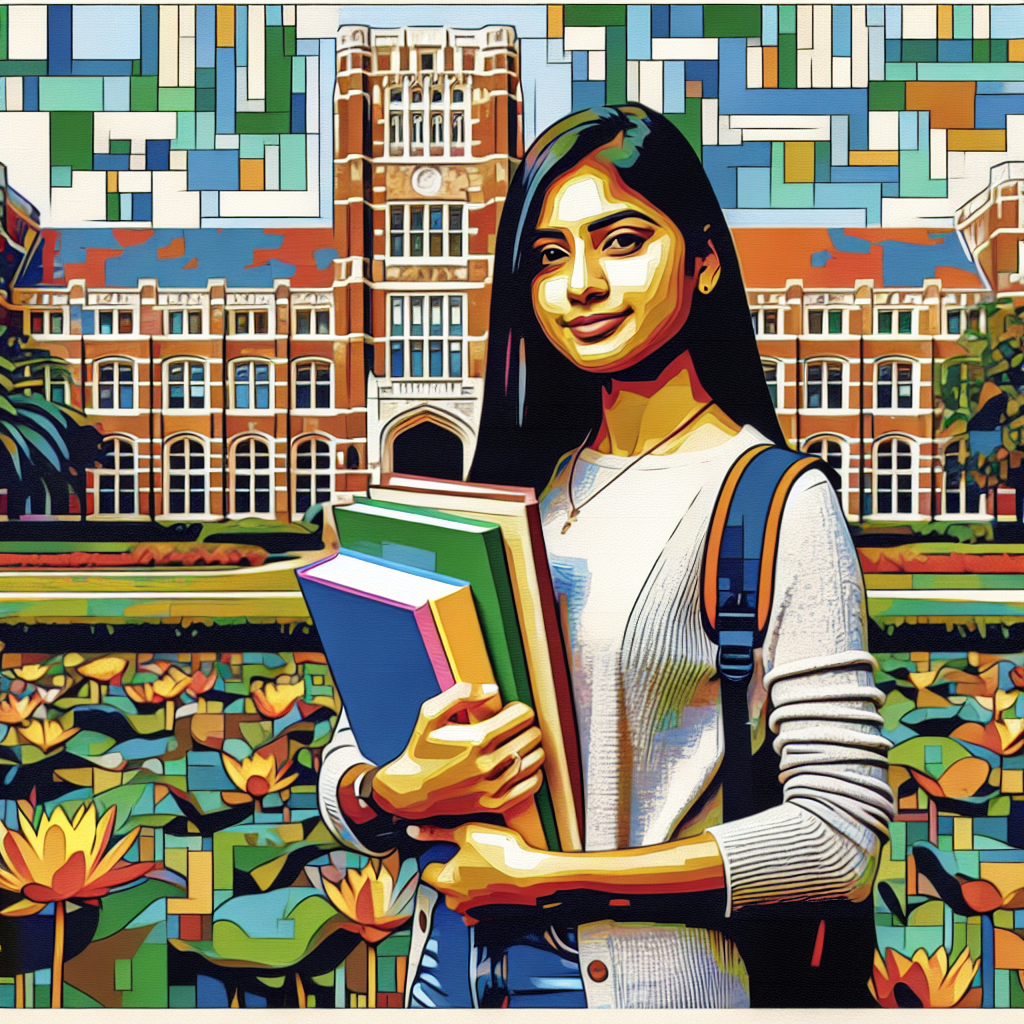

In [14]:
artist('university of florida')

In [35]:
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

In [36]:
def chat(history):
    messages = [{'role': 'system', 'content': system_prompt}] + history
    response_stream = openai.chat.completions.create(
        model=MODEL,
        messages=messages,
        stream=True,
        tools=tools
    )

    image = None
    response = ""
    tool_call_data = None
    tool_call_args = ""

    for chunk in response_stream:
        choice = chunk.choices[0]

        if choice.finish_reason == "tool_calls":
            if tool_call_data:
                tool_call_data["arguments"] = tool_call_args
                tool_response, university_name = handle_tool_calls(tool_call_data)
                messages.append(tool_response)
                image = artist(university_name)

                response_stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)
                for chunk in response_stream:
                    if chunk.choices[0].delta.content:
                        response += chunk.choices[0].delta.content
            continue

        if choice.delta.tool_calls:
            for tool_call in choice.delta.tool_calls:
                if tool_call.id and not tool_call_data:
                    tool_call_data = {
                        "id": tool_call.id,
                        "function": tool_call.function.name,
                        "arguments": ""
                    }
                if tool_call.function.arguments:
                    tool_call_args += tool_call.function.arguments
        elif choice.delta.content:
            response += choice.delta.content
            print(choice.delta.content, end="", flush=True)

    history.append({"role": "assistant", "content": response})
    
    talker(response)
    
    return history, image       

In [37]:

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Hello! How can I assist you today?

I can help you analyze your interests, goals, and aspirations to suggest suitable career options. Just share a bit about what you're passionate about or what you hope to achieve, and I'll provide some recommendations!

Based on your interests and goals, you could consider a career in education, specifically as a math or computer science teacher. This role combines your love of teaching, mathematics, and programming while providing opportunities to meet new people. 

Another option is to become a data analyst or software engineer. Both fields require strong mathematical and logical skills, offer strong earning potential to help you escape financial problems, and often allow for collaboration with others. 

Additionally, you might explore roles in educational technology, where you can develop tools to assist in teaching, blending your programming skills and desire to help others.